In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/Covid Data'


/content/drive/My Drive/Covid Data


In [ ]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:

#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/content/drive/My Drive/Covid Data/Ct/Covid'
noncovid_path = '/content/drive/My Drive/Covid Data/Ct/NonCovid'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['/content/drive/My Drive/Covid Data/Ct/Covid/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png', '/content/drive/My Drive/Covid Data/Ct/Covid/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png', '/content/drive/My Drive/Covid Data/Ct/Covid/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png', '/content/drive/My Drive/Covid Data/Ct/Covid/2020.01.24.919183-p27-132.png', '/content/drive/My Drive/Covid Data/Ct/Covid/2020.01.24.919183-p27-133.png']
Total Count:  348
First 5 NonCovid Files:  ['/content/drive/My Drive/Covid Data/Ct/NonCovid/aff stri full - Page 7.jpg', '/content/drive/My Drive/Covid Data/Ct/NonCovid/0.jpg', '/content/drive/My Drive/Covid Data/Ct/NonCovid/1%0.jpg', '/content/drive/My Drive/Covid Data/Ct/NonCovid/1%1.jpg', '/content/drive/My Drive/Covid Data/Ct/NonCovid/10%0.jpg']
Total Count:  325


In [ ]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

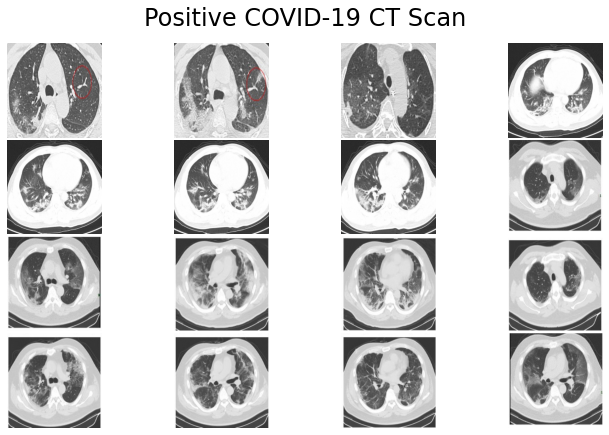

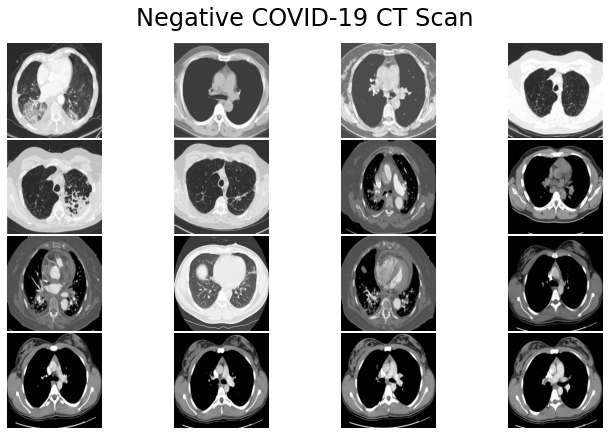

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 4, 4
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

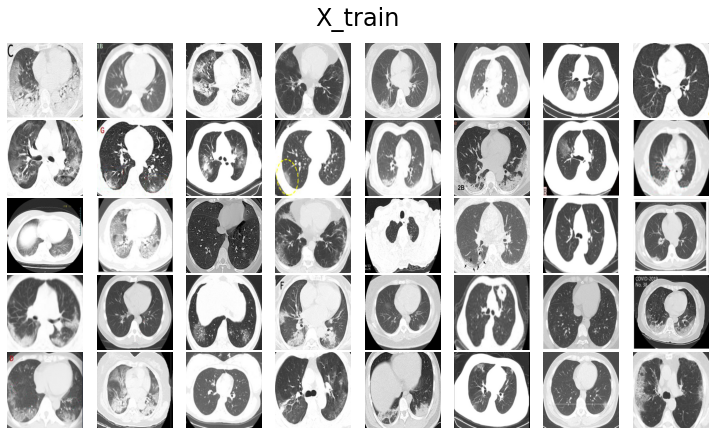

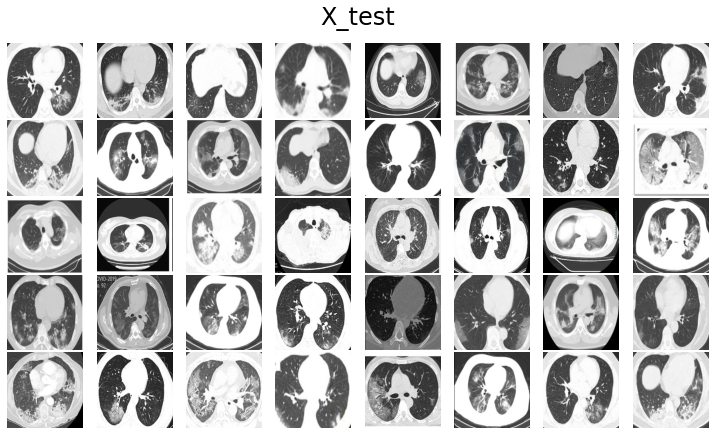

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [ ]:
# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:

history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=2)

Epoch 1/2
16/16 [==============================] - 102s 6s/step - loss: 2.7112 - accuracy: 0.5056 - val_loss: 2.5611 - val_accuracy: 0.5185
Epoch 2/2
16/16 [==============================] - 97s 6s/step - loss: 1.8702 - accuracy: 0.5056 - val_loss: 1.0567 - val_accuracy: 0.5630


In [ ]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:

# Load saved model
model = load_model('resnet_ct.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

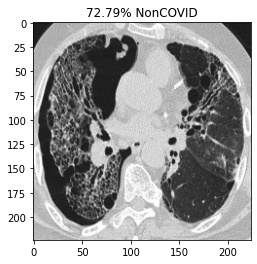

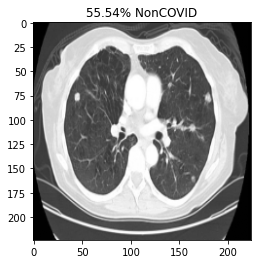

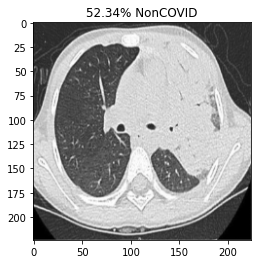

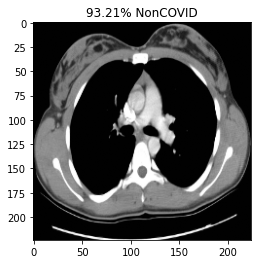

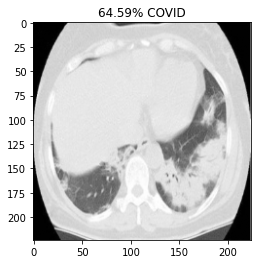

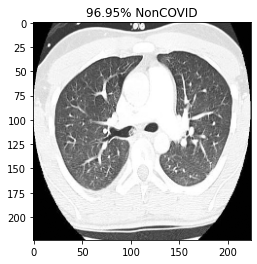

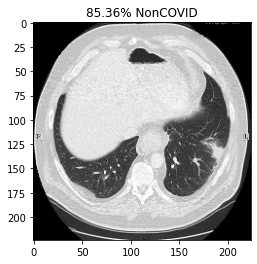

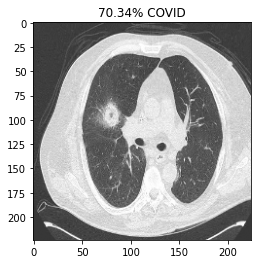

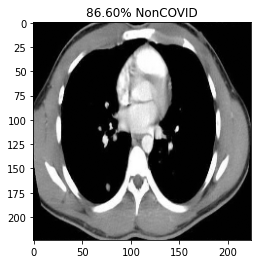

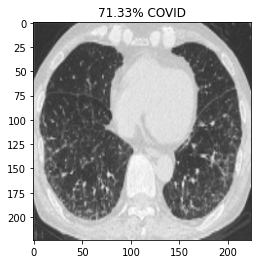

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56        70
           1       0.54      0.58      0.56        65

    accuracy                           0.56       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.56      0.56      0.56       135

